Let's move into a test folder and download NIAK. 

In [2]:
cd /home/pbellec/tmp
system('wget https://github.com/SIMEXP/niak/archive/v0.16.0.zip')
system('unzip v0.16.0.zip')

--2016-09-21 10:30:34--  https://github.com/SIMEXP/niak/archive/v0.16.0.zip
Resolving github.com (github.com)... 192.30.253.112
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/SIMEXP/niak/zip/v0.16.0 [following]
--2016-09-21 10:30:35--  https://codeload.github.com/SIMEXP/niak/zip/v0.16.0
Resolving codeload.github.com (codeload.github.com)... 192.30.253.121
Connecting to codeload.github.com (codeload.github.com)|192.30.253.121|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 56844510 (54M) [application/zip]
Saving to: ‘v0.16.0.zip.1’

v0.16.0.zip.1       100%[===================>]  54.21M  2.26MB/s    in 28s     

2016-09-21 10:31:02 (1.96 MB/s) - ‘v0.16.0.zip.1’ saved [56844510/56844510]

ans = 0
Archive:  v0.16.0.zip
1daac608dc87cd2bf26edc240221747bebbe50b9
   creating: niak-0.16.0/
 extracting: niak-0.16.0/.gitignore  
 extracting: niak-0.16.0/.gitm

Let's add NIAK to the matlab search path

In [3]:
addpath(genpath('/home/pbellec/tmp/niak-0.16.0'))

We are going to simulate data with a cluster structure. Let's assume we have 100 subjects, 300 brain regions and 3 clusters. 

In [15]:
nb_subject = 100;
nb_roi = 300;
nb_cluster = 3;
alpha = 0.3; % this parameter controls the "strength" of the clustering. 
y = randn(nb_subject,nb_roi);
ind = floor(linspace(1,nb_roi,nb_cluster+1));
for cc = 1:nb_cluster
    cluster = ind(cc):ind(cc+1);
    y(:,cluster) = y(:,cluster) + alpha*repmat(randn(nb_subject,1),[1 length(cluster)]);
end

We compute the spatial correlation matrix (across subjects) to see how the cluster structure looks.  

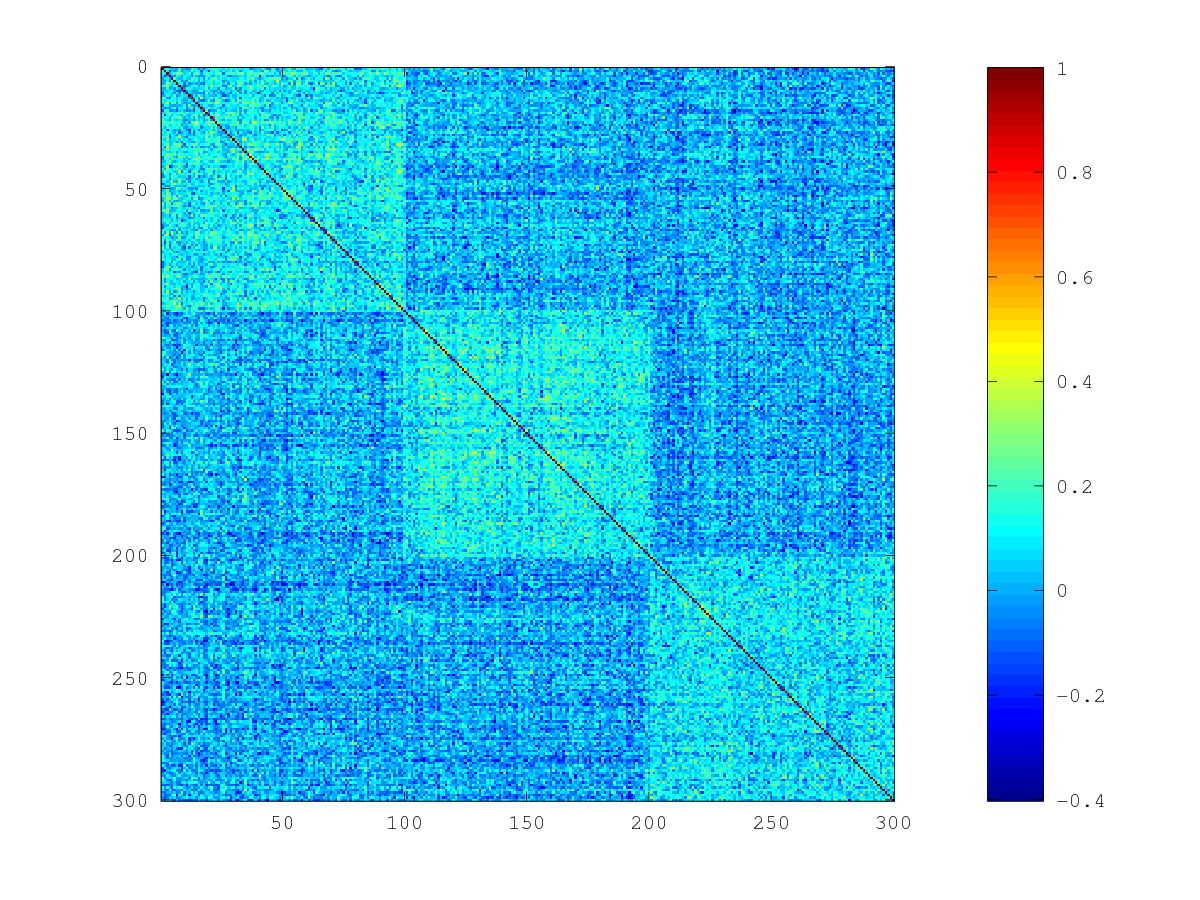

In [22]:
R = corr(y);
imagesc(R), axis square, colormap(jet), colorbar

the cluster structure is clear, but noisy. Let's run a hierarchical clustering and see if we can recover it. 

     Percentage done : 0 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100 Done ! 


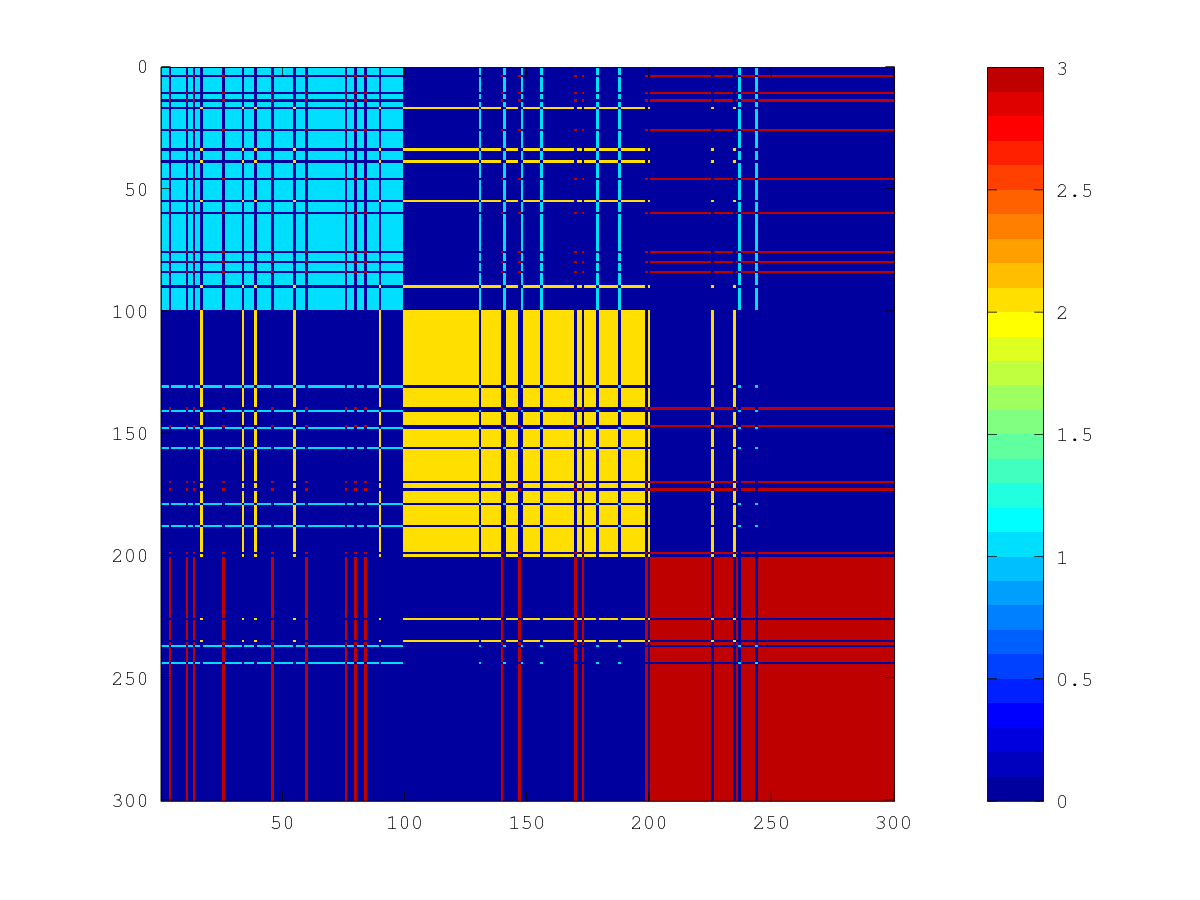

In [18]:
hier = niak_hierarchical_clustering(R);
part = niak_threshold_hierarchy(hier,struct('thresh',3));
niak_visu_part(part)

In this representation, if a pair of region is in cluster I, a I is shown in the matrix. If the clustering had done a perfect job, we would have squares on the diagonal. Note that th adjacency matrix representation of the clustering is the same as this representation, but with all non-zero entries coded as 1 (we don't care about the actual label of clusters, as these are arbitrary). It looks like the hierarchical clustering did an OK job here. 

A small aside note here. Note that we simulated the data with a simple order (cluster 1, then cluster 2, etc). In real life we don't know the order. We can use the hierarchical clustering to estimate it though:

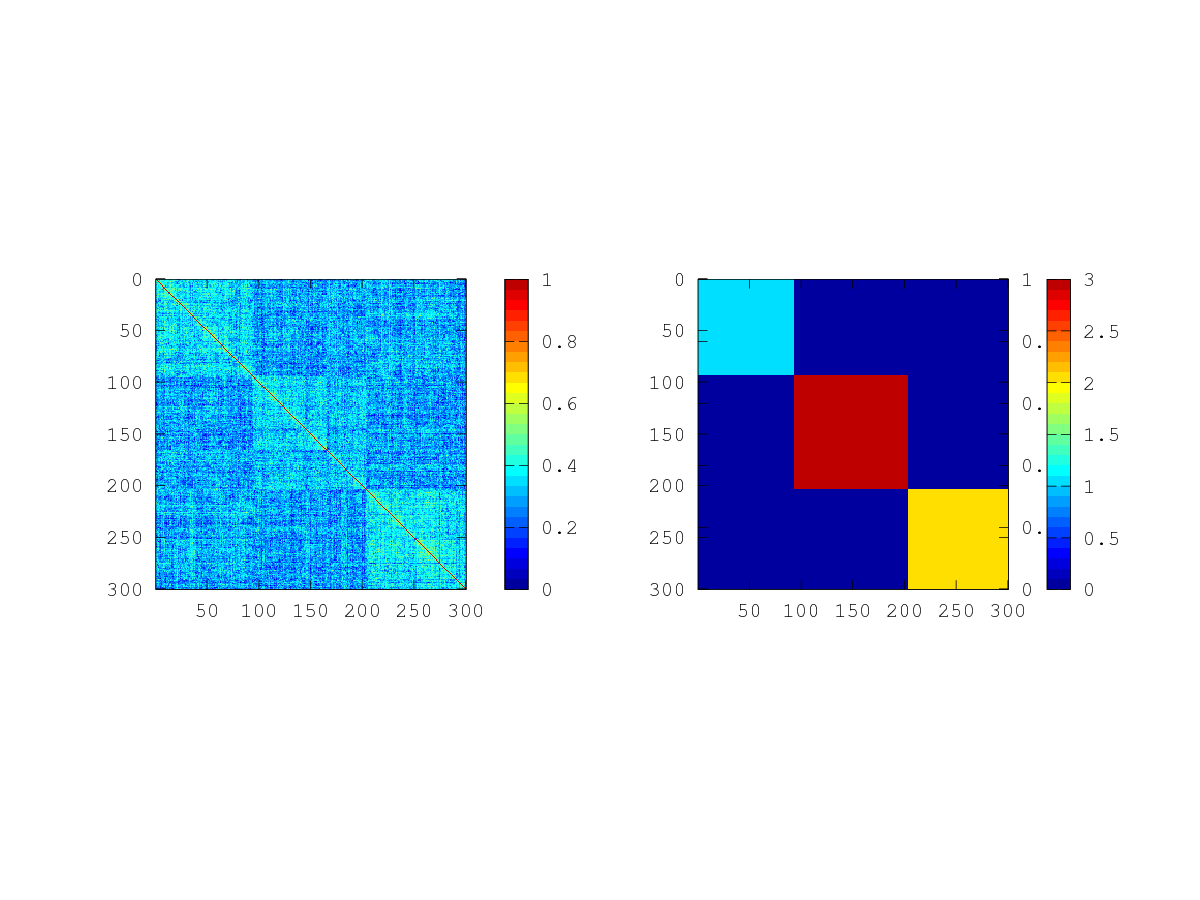

In [21]:
order = niak_hier2order(hier);
subplot(1,2,1)
imagesc(R(order,order)), axis square, colorbar
subplot(1,2,2)
niak_visu_part(part(order)), axis square

with that ordering, by construction the solution of the hierarchical clustering are squares on the diagonal. If you are lucky, the similarity matrix will also look like it has squares on the diagonal.  

Now is time to implement a boostrap analysis of stable clusters. The steps of the algorithm are as follows: 
 * Let's start by resample the data many times
 * re-run the clustering on each replication
 * represent each cluster solution as an adjacency matrix
 * compute the average of the adjacency matrix. This matrix, called stability or co-occurence, tells you the frequency at which a pair of regions fall into the same cluster. 

In [27]:
nb_samp = 30;
opt_b.block_length = 1; % That's a parameter for the bootstrap. We treat the subjects as independent observations. 
for ss = 1:nb_samp
    niak_progress(ss,nb_samp)
    y_s = niak_bootstrap_tseries(y,opt_b);
    R_s = corr(y_s);
    hier = niak_hierarchical_clustering(R_s,struct('flag_verbose',false));
    part = niak_threshold_hierarchy(hier,struct('thresh',nb_cluster));
    mat = niak_part2mat(part,true);
    if ss == 1; stab = mat; else stab = stab+mat; end;
end
stab = stab / nb_samp;

    Percentage done: 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100


Let's have a look at the stability matrix:

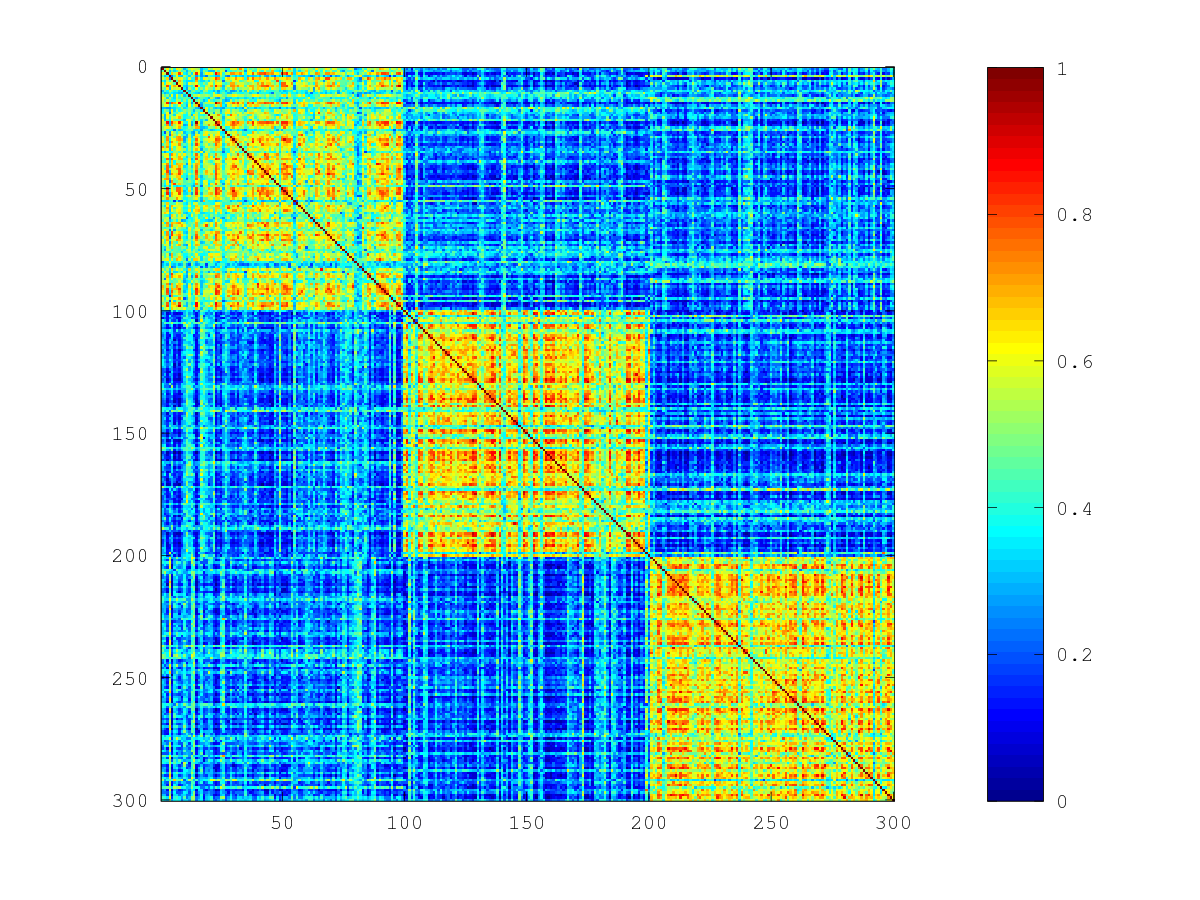

In [28]:
imagesc(stab), axis square, colormap(jet), colorbar

Looks like the clusters are pretty stable. Also note that the stability matrix ressembles a lot the original similarity matrix, except that the cluster structure is much cleaner. So let's use this stability matrix as the input of a new clustering! We are now looking for clusters of regions which have a high probability of falling into the same clusters. This step is called consensus clustering. 

     Percentage done : 0 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100 Done ! 


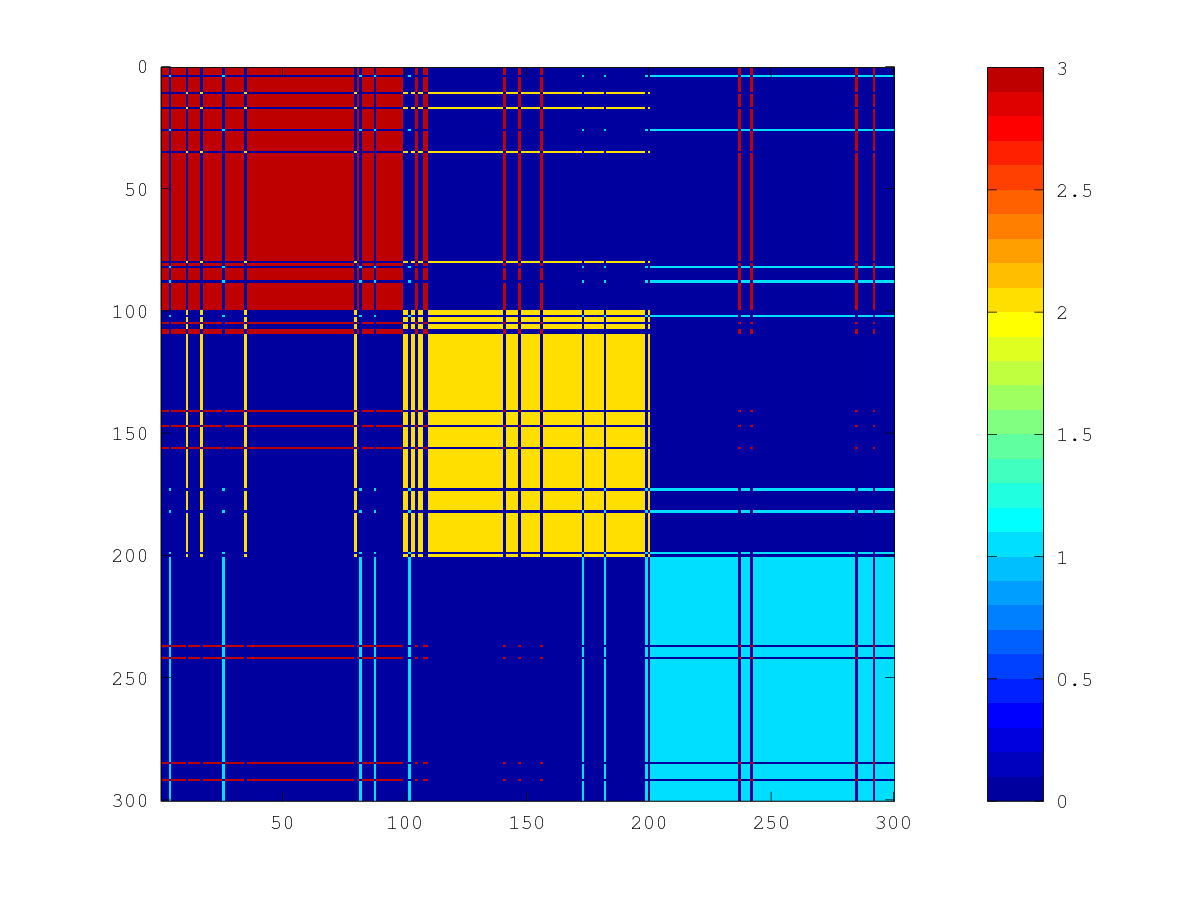

In [29]:
hier_consensus = niak_hierarchical_clustering(stab);
part_consensus = niak_threshold_hierarchy(hier_consensus,struct('thresh',nb_cluster));
niak_visu_part(part_consensus), axis square, colormap(jet)

Still not perfect but a bit better... In general the consensus cluster has better performance than the individual cluster solution. This is a general machine learning approach called bagging (for bootstrap aggregation).

One last question. Which region in the consensus cluster #1 (for example) are actually stable? We can combine the sability matrix and the consensus clusters to answer this question. 

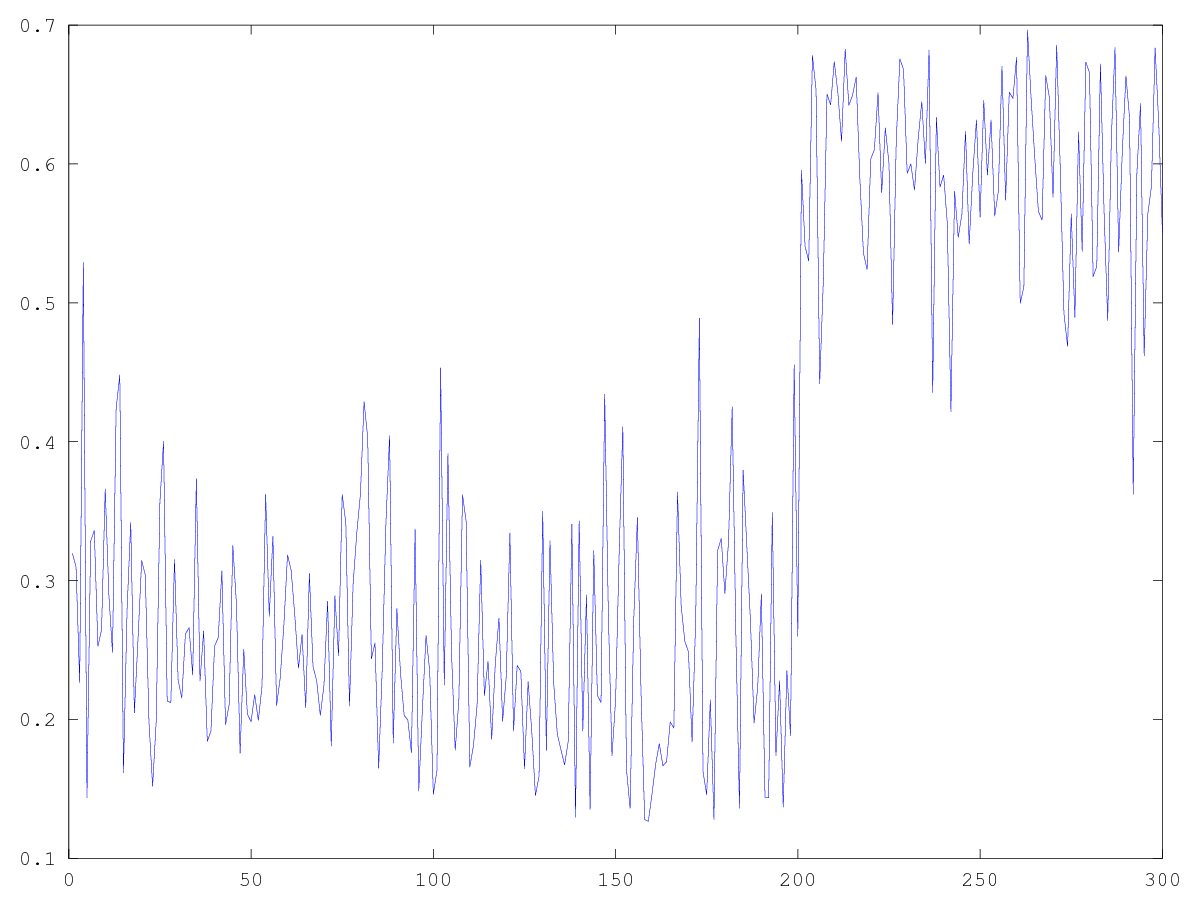

In [30]:
map = mean(stab(:,part_consensus==1),2);
plot(map)

For each region, we have the average stability between this region and all regions in consensus cluster #1 (which happen to be very close to our simulated cluster #3). For regions in the true cluster, the stability is about 0.6, while inother regions, it is about 0.25. Not bad. An ideal situation would be 1 within cluster, and 0 between cluster. We can also see each region happen to be less stable in that cluster. If each region corresponded to a parcel in the brain, we could represent this vector as a brain map. 